# Comparison to the Water Budget

We want to compare the changes of our reconstructed water storage anomalies to the water balance equation, calculated from ERA5.

In [ ]:
from typing import Literal

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deepwaters  # noqa
from deepwaters import metrics
from deepwaters.regions import basins
from deepwaters.utils import ROOT_DIR
from deepwaters.visualization import plot_basinwise_map, plot_grace_gap

sns.set_style("whitegrid")
# plt.tight_layout() per default
mpl.rcParams["figure.autolayout"] = True
# Higher figure resolution
set_matplotlib_formats("retina")

# Register dask progress bar
ProgressBar(minimum=5).register()

## Data Preprocessing

### Data Loading

Load and combine the different data sets (GRACE, ERA5, WGHM, and our and other reconstructions)

In [ ]:
# Zarr store paths
stores = [
    ROOT_DIR / "data/processed/targets.zarr",
    ROOT_DIR / "data/processed/inputs.zarr",
    ROOT_DIR / "data/processed/reconstructions.zarr",
    ROOT_DIR / "models/predictions/global/ensemble_alltrain_10folds_combined.zarr",
]
ds_all = xr.merge([xr.open_zarr(store) for store in stores])

ds_all

<xarray.Dataset> Size: 69GB
Dimensions:                                    (lat: 360, lon: 720, time: 1480)
Coordinates:
  * lat                                        (lat) float64 3kB -89.75 ... 8...
  * lon                                        (lon) float64 6kB -179.8 ... 1...
  * time                                       (time) datetime64[ns] 12kB 190...
Data variables: (12/59)
    land_mask_gsfc                             (lat, lon) float32 1MB dask.array<chunksize=(360, 720), meta=np.ndarray>
    land_mask_jpl                              (lat, lon) float32 1MB dask.array<chunksize=(360, 720), meta=np.ndarray>
    twsa_csr                                   (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 360, 180), meta=np.ndarray>
    twsa_gsfc                                  (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 360, 180), meta=np.ndarray>
    twsa_jpl                                   (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 360, 180), meta=np.ndarray>
    cell_area                                  (lat, lon) float32 1MB dask.array<chunksize=(360, 720), meta=np.ndarray>
    ...                                         ...
    yin_jpl_full                               (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_jpl_zerofill                           (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    pred_ensemble_alltrain_gap_lnll_latest     (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    pred_ensemble_alltrain_nogap_lnll_latest   (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_gap_lnll_latest    (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_nogap_lnll_latest  (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
Attributes: (12/53)
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    C_20_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    GIA_removed:                   ICE6G-D; Peltier, W. R., D. F. Argus, and ...
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    ...                            ...
    time_coverage_start:           2002-04-16T00:00:00Z
    time_epoch:                    2002-01-01T00:00:00Z
    time_mean_removed:             2004.000 to 2009.999
    title:                         JPL GRACE and GRACE-FO MASCON RL06.1Mv03 CRI
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...

In [ ]:
# rename variables containing twsa in their name
renamer = {
    dvar: dvar.removeprefix("twsa_") for dvar in ds_all.data_vars if "twsa_" in dvar
}
renamer

{'twsa_csr': 'csr',
 'twsa_gsfc': 'gsfc',
 'twsa_jpl': 'jpl',
 'twsa_gap': 'gap',
 'twsa_gap_detrended_5yrs': 'gap_detrended_5yrs'}

In [ ]:
vars_verbose = {
    "pred_ensemble_alltrain_gap_lnll_latest": "DeepWaters (Ours)",
    "pred_ensemble_alltrain_nogap_lnll_latest": "DeepWaters w/ WGHM (Ours)",
    "gap": "WGHM",
    "humphrey_gsfc_detrend": "Humphrey's GSFC Rec",
    "li_csr_full": "Li's CSR Rec",
    "yin_csr_full": "Yin's CSR Rec",
    "csr": "GRACE CSR-M",
}

In [ ]:
# Variables of interest
grace_var = "csr"
eval_vars = vars_verbose.keys()
era_vars = ["era5_tp", "era5_e", "era5_ro"]

In [ ]:
# Create and apply land mask
mask = (ds_all.land_mask_jpl * ds_all.land_mask_gsfc * ds_all.grl_ata_mask).compute()
ds_all = ds_all.rename(renamer).where(mask == 1)


We generate basin scale time-series by averaging all grid points of basins larger than 200 000 km².

In [ ]:
CALC = False

twsa_basin_path = ROOT_DIR / "data/evaluations/twsa_basin-scale.zarr"

if CALC:
    ds_basin = (
        # Select variables and time frame of interest
        ds_all[[*eval_vars, *era_vars]]
        .sel(time=slice("1940", None))
        .chunk(time=10, lat=-1, lon=-1)
        .dw.select_basins(top=72)
        .dw.weight_lat()
        .mean(["lat", "lon"])
        .compute()
    )
    ds_basin.to_zarr(twsa_basin_path, mode="w")
else:
    ds_basin = xr.open_zarr(twsa_basin_path)

ds_basin

<xarray.Dataset> Size: 6MB
Dimensions:                                   (region: 72, time: 1012)
Coordinates:
  * region                                    (region) object 576B 'Congo' .....
  * time                                      (time) datetime64[ns] 8kB 1940-...
Data variables:
    csr                                       (region, time) float64 583kB dask.array<chunksize=(36, 1012), meta=np.ndarray>
    era5_e                                    (region, time) float64 583kB dask.array<chunksize=(36, 1012), meta=np.ndarray>
    era5_ro                                   (region, time) float64 583kB dask.array<chunksize=(36, 1012), meta=np.ndarray>
    era5_tp                                   (region, time) float64 583kB dask.array<chunksize=(36, 1012), meta=np.ndarray>
    gap                                       (region, time) float64 583kB dask.array<chunksize=(36, 1012), meta=np.ndarray>
    humphrey_gsfc_detrend                     (region, time) float64 583kB dask.array<chunksize=(36, 1012), meta=np.ndarray>
    li_csr_full                               (region, time) float64 583kB dask.array<chunksize=(36, 1012), meta=np.ndarray>
    pred_ensemble_alltrain_gap_lnll_latest    (region, time) float64 583kB dask.array<chunksize=(36, 1012), meta=np.ndarray>
    pred_ensemble_alltrain_nogap_lnll_latest  (region, time) float64 583kB dask.array<chunksize=(36, 1012), meta=np.ndarray>
    yin_csr_full                              (region, time) float64 583kB dask.array<chunksize=(36, 1012), meta=np.ndarray>

### GRACE time step interpolation

We did not perform interpolation when using GRACE as a target. In this evaluation, GRACE only serves as a comparison and continuous time steps are important for the subsequent differentiation, so we perform a quadratic interpolation.

In [ ]:
def grace_time_interp(
    da: xr.DataArray, method: Literal["linear", "quadratic", "cubic"] = "linear"
) -> xr.DataArray:
    # Remove missing time steps
    da = da.dropna("time", how="all")

    # Create full time index without missing steps
    grace_time = da.get_index("time")
    start, end = grace_time[0], grace_time[-1]
    full_time = pd.date_range(start, end, freq="MS")

    # Perform interpolation of missing time steps
    return da.interp(time=full_time, method=method)

In [9]:
# Before interpolation, split in GRACE and GRACE-FO
# Due to the long gap, we have to perform the interpolation on them individually
grace_og = ds_basin[grace_var].sel(time=slice(None, "2018-01"))
grace_fo = ds_basin[grace_var].sel(time=slice("2018-01", None))

# Perform interpolation
grace_og = grace_time_interp(grace_og, method="quadratic")
grace_fo = grace_time_interp(grace_fo, method="quadratic")

# Combine GRACE and GRACE-FO
grace_interp = xr.concat([grace_og, grace_fo], dim="time").rename("csr_interp")

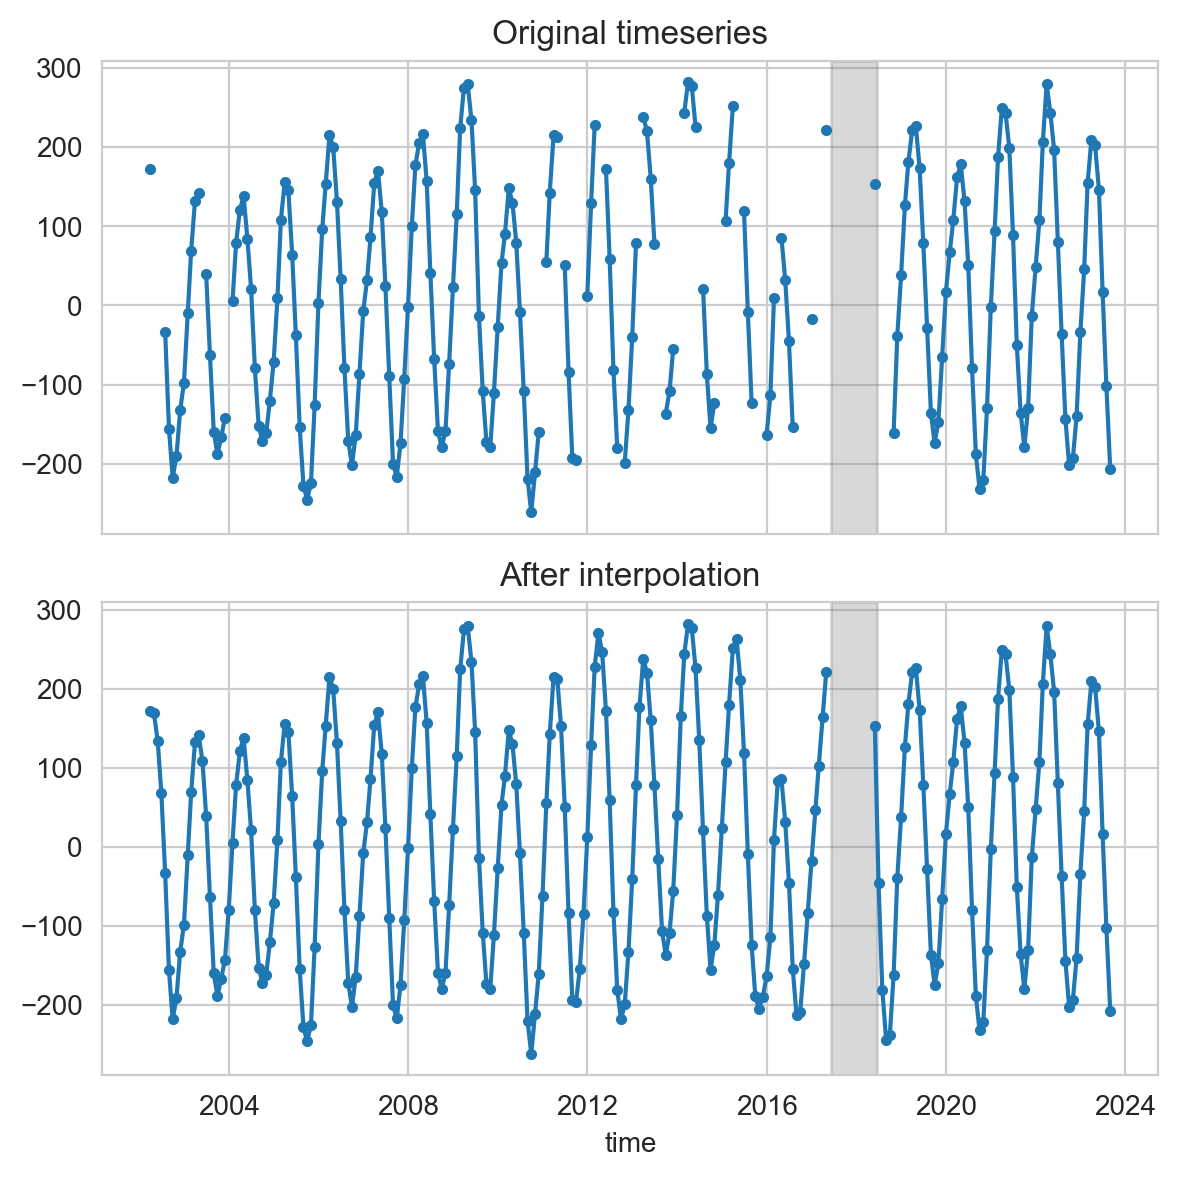

In [ ]:
# Plot the result
p = (
    xr.merge([ds_basin[grace_var], grace_interp])
    .to_dataarray()
    .sel(region="Amazon")
    .dw.insert_grace_gap_nans()
    .plot(row="variable", marker=".", figsize=(6, 6))
)
axs = p.axs.flat
axs[0].set_title("Original timeseries")
axs[1].set_title("After interpolation")
for ax in axs:
    plot_grace_gap(ax)

In [ ]:
# Replace GRACE time series with interpolation
ds_basin[grace_var] = grace_interp

### Calculate the TWSC from the reconstructions

For this, we have to calculate the water storage changes with the central difference:

$$  \text{TWSC}(t) = \frac{\text{TWS}(t + 1) - \text{TWS}(t - 1)}{2 \Delta t} $$

$\Delta t$ is our base time interval, 1 month.

In [ ]:
T_DELTA = 1

tws_eval = ds_basin[eval_vars]
forward_shift = tws_eval.shift(time=-1)
backward_shift = tws_eval.shift(time=1)
twsc_eval = (forward_shift - backward_shift) / (2 * T_DELTA)

### Calculate the TWSC from ERA5

We calculate the TWSC first with the ERA5 components according to the water balance equation:

$$ \text{TWSC} = \frac{d\text{TWS}}{dt} = P - ET - R $$

According to the ECMWF Integrated Forecasting System (IFS) convention, downward fluxes are positive. We therefore have to add $ET$ instead if subtracting it in our implementation.

In [ ]:
MM_PER_M = 1000
DAYS_PER_MONTH = 365.25 / 12

# Evaporation is negatively defined, so add instead of subtract
twsc_bdgt = ds_basin.era5_tp + ds_basin.era5_e - ds_basin.era5_ro
# Convert from m/day to mm/month
twsc_bdgt *= MM_PER_M * DAYS_PER_MONTH

We use the following equation to match the temporal shift induced by the central difference:

$$ \tilde X = \frac{1}{4} X(t-1) + \frac{1}{2} X(t) + \frac{1}{4} X(t+1) $$

We implement this for our Xarray data array by averaging over a weighted rolling window:

In [20]:
weights = xr.DataArray(np.array([1.0, 2.0, 1.0], dtype="float32"), dims="time_roll")

twsc_bdgt_smooth = (
    twsc_bdgt.dropna("time", how="all")
    .rolling(time=3, center=True)
    .construct("time_roll")
    .weighted(weights)
    .mean("time_roll", skipna=False)
)

### Combine and save

In [ ]:
twsc_basin_path = ROOT_DIR / "data/evaluations/twsc_basin-scale.zarr"

twsc = (
    xr.merge(
        [twsc_eval, twsc_bdgt.rename("era5"), twsc_bdgt_smooth.rename("era5_smooth")]
    )
    .drop_encoding()
    .chunk(region=-1, time=-1)
)
twsc.to_zarr(twsc_basin_path, mode="w")

### Validation

Compare our calculations for a single basin

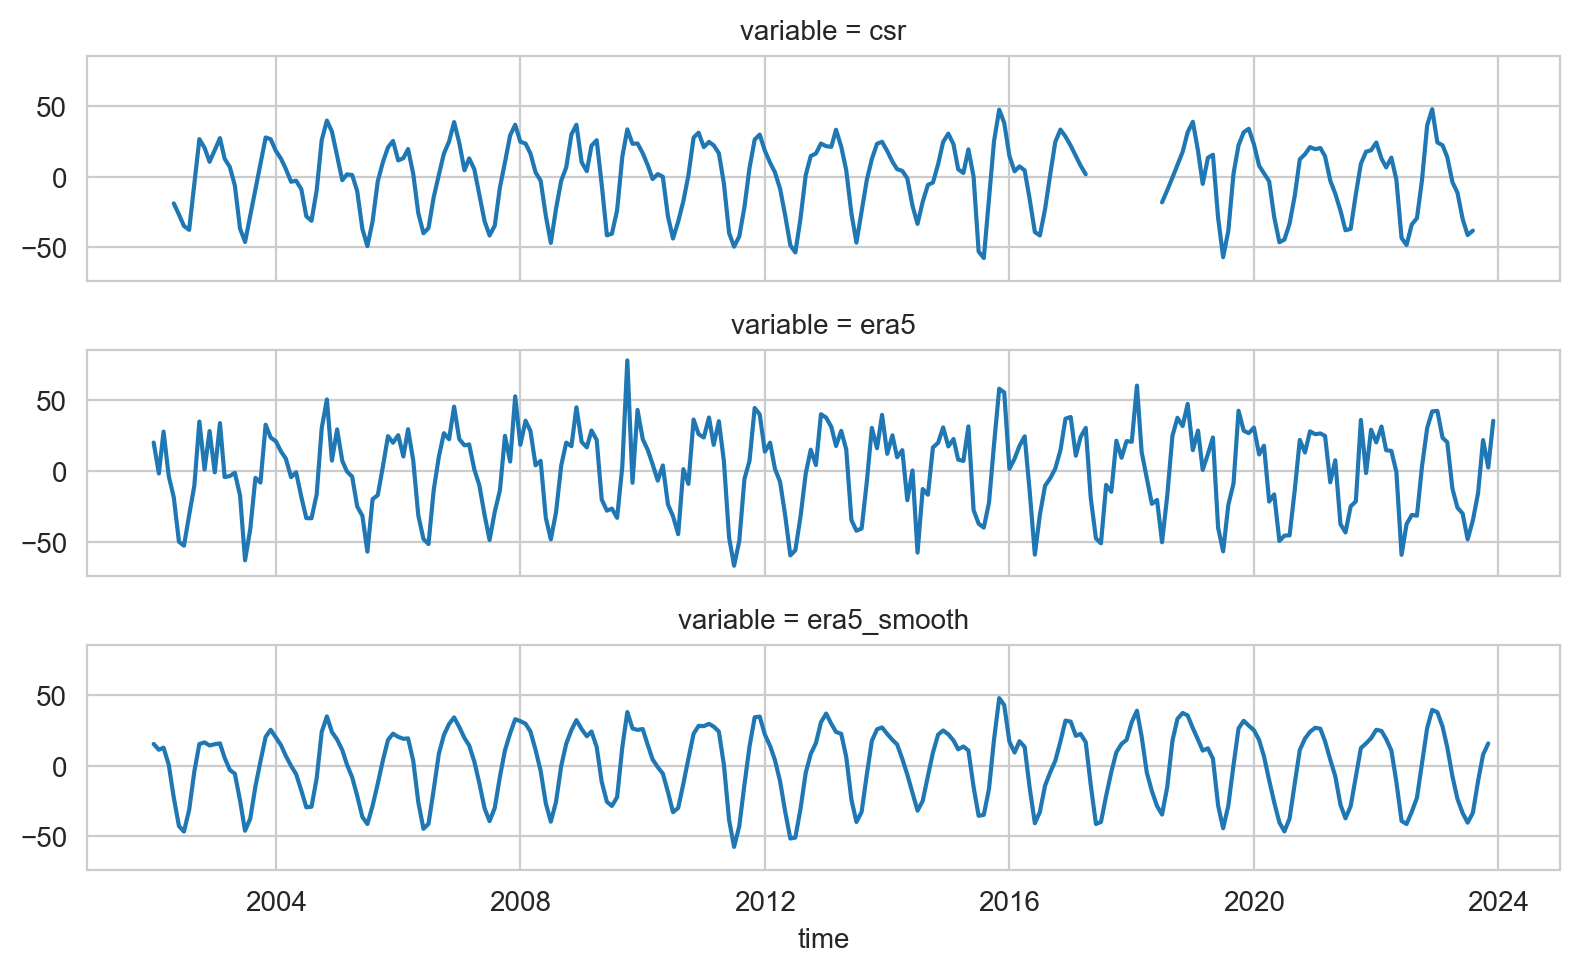

In [ ]:
da_plot = (
    twsc[["csr", "era5", "era5_smooth"]]
    .sel(region="Mississippi", time=slice("2002", "2023"))
    .to_dataarray()
)
da_plot.plot(row="variable", figsize=(8, 5))